# Fingerprint GAN Research

This document contains some of the work for my Master's from 2021, which I never finished. I ended up lossig some of my work, so I had to create it. 

## Introduction

An open problem in the area of Latent Fingerprint Recognition is the enhancement of poor quality fingerprints for the purpose of improving fingerprint matching accuracy. Although there a lots of algorithms out there to enhance fingerprint images, the results of some of the best solutions are less than satisfactory. For this reason, my research was on the use of Generative Adversarial Networks for the purpose of enhacing images of latent fingerprints for improving matching accuracy.

This GAN was adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. It is similar to traditional GANs, but its discriminator consists of 2 parts. The first is the normal discriminator that attempts to determine if a generated image is real of fake. The second part of this GAN is a Siamese Neural Network, which is used to try and enforce similair ridge structure between the original fingerprint image and the GAN Enhanced fingerprint. This Siamese Neural Network was adapted from https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py for comparing images or characters. 

The loss from these 2 parts of the discriminator are combined to determine the total loss for the discriminator. In doing this, the hope is that the trained GAN would be able to Generate realistic binary enhanced fingerprints from poor fingerprint images, while also preserving the underlying ridge structure. 

## Install Dependencies

In [9]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
%reload_ext autoreload
%autoreload

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation

## Config

In [11]:
target_dir   = "../../storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "../../storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

model_results_file = "checkpoint/GAN_results.pt"
model_ckpt_file = "checkpoint/GAN_with_SSNN_checkpoint.pt"

im_size = (300, 300)
var_max = 0.5

num_train = 10000
num_valid = 1000
batch_size = 32
num_workers = 1
shuffle = True
augment = True

# Number of training epochs
num_epochs = 5
start_epoch = 1

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 256
# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
dlr = 0.0002
glr = 0.0002
slr = 0.000002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Utils

In [12]:
def saveCkpt(filepath, epoch, netG, netD, netS, optimizerG, optimizerD, optimizerS, G_losses, D_losses, S_losses, img_list, test_batch, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netG_state_dict' : netG.state_dict(),
        'netD_state_dict' : netD.state_dict(),
        'netS_state_dict' : netS.state_dict(),
        'optimizerG_state_dict' : optimizerG.state_dict(),
        'optimizerD_state_dict' : optimizerD.state_dict(),
        'optimizerS_state_dict' : optimizerS.state_dict(),
        'G_losses' : G_losses,
        'D_losses' : D_losses,
        'S_losses' : S_losses,
        'img_list' : img_list,
        'test_batch' : test_batch,
        'iters' : iters,
    }, filepath)


def showImages(batch, labels=None):
    """
    Displays a set of batch images
    
    :param batch: A batch of image pairs and labels to display
    :praam labels: The labels for the images
    """
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()
    
    if labels is not None:
        for l in labels:
            if l == 1:
                print("  same  ", end=" ")
            else:
                print("  diff  ", end=" ")
        
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up synthetically generating my own dataset using this software: https://dsl.cds.iisc.ac.in/projects/Anguli/https://dsl.cds.iisc.ac.in/projects/Anguli/. This generated dataset contains close to one million fingerprint images of varying qualities, which includes 10,000 unique fingerprints. 

In [13]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train 
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    #random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader)



def get_train_valid_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7500]
    validation_prints = fingerprints[7500:]
    
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # Get the Validation Dataloader 
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)
    

class FingerprintLoader(Dataset):
    """
    This class is used to help load the celeba dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset):
        """
        Initializes an instance for the FingerprintLoader class.

        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against 
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = dataset
        self.num_train = num_train
        self.augment = augment

    def __len__(self):
        """
        Helper function to return the length of the dataset

        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset

        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        template_im_filepath = "templateim.jpg"
        template_im_path = ""
        target_im_filepath = "targetim.jpg" 
        enhanced_target_im_filepath = "targetim.jpg"
        
        while not os.path.isfile(template_im_filepath) or not os.path.isfile(target_im_filepath):
            # Chose image 1
            while not os.path.isfile(template_im_filepath):
                template_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset))
                template_im_filepath +=  "/Impression_1/"
                template_im_name = random.choice(self.fingerprints_dataset)
                template_im_filepath += template_im_name + '.jpg'
            # Decide if image is same or not
            label = random.randint(0, 1)
            # Choose image 2
            while not os.path.isfile(target_im_filepath) or not os.path.isfile(enhanced_target_im_filepath):
                target_im_filepath = self.target_dataset + random.choice(os.listdir(self.target_dataset))
                target_im_filepath +=  "/Impression_1/"
                if label == 1:
                    target_im_name = template_im_name
                else:
                    target_im_name = template_im_name
                    while target_im_name == template_im_name:
                        target_im_name = random.choice(self.fingerprints_dataset)
                target_im_filepath = target_im_filepath + target_im_name + '.jpg'
                enhanced_target_im_filepath = self.template_dataset + random.choice(os.listdir(self.template_dataset)) \
                    + "/Impression_1/" + target_im_name + '.jpg'

        label = float(label)
        # Convert images to grayscale
        temp_im = Image.open(template_im_filepath)
        temp_im = temp_im.convert('L')
        targ_im = Image.open(target_im_filepath)
        targ_im = targ_im.convert('L')
        enhanced_targ_im = Image.open(enhanced_target_im_filepath)
        enhanced_targ_im = enhanced_targ_im.convert('L')
        # Pad template image
        w, h = temp_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        template_image = Image.new(temp_im.mode, (dim, dim), 255)
        template_image.paste(temp_im, (left, top))
        # Pad target image
        w, h = targ_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        target_image = Image.new(targ_im.mode, (dim, dim), 255)
        target_image.paste(targ_im, (left, top))
        # Pad enhanced target image
        w, h = enhanced_targ_im.size
        dim = max(w, h)
        left = int((dim - w) / 2.0)
        top = int((dim - h) / 2.0)
        enhanced_target_image = Image.new(enhanced_targ_im.mode, (dim, dim), 255)
        enhanced_target_image.paste(enhanced_targ_im, (left, top))
        # apply transformation on the fly
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                #transforms.CenterCrop(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        target_image = trans(target_image)
        enhanced_target_image = trans(enhanced_target_image)
        template_image = trans(template_image)
        y = torch.from_numpy(np.array([label], dtype=np.float32))
        return target_image, enhanced_target_image, template_image, y

## Data Visualization for the Siamese Neural Network
Below are some sample images that the Siamese Neural Network will be trained on.

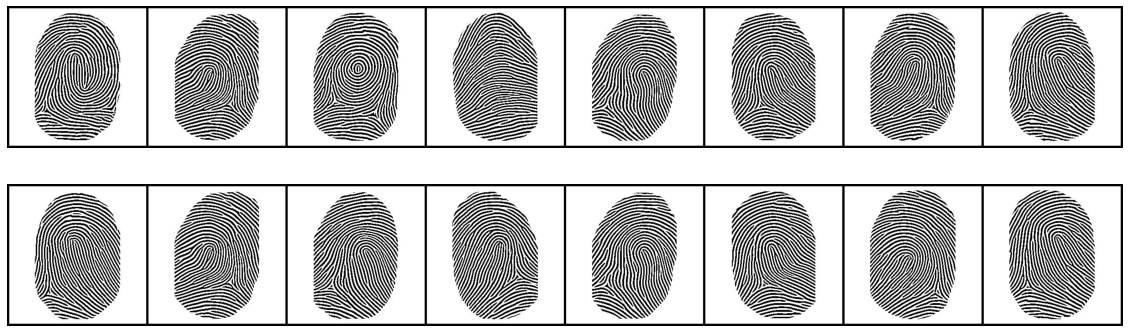

        diff                same               diff                diff               same                same               diff                same       

In [14]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=8,
                                         shuffle=True, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch
labels = real_batch[3]

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[2].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

c = 0
if labels is not None:
    for l in labels:
        if l == 1:
            print("        same       ", end="")
        else:
            print("        diff       ", end="")
        if c % 2 == 0:
            print(" ", end="")
        c += 1

## Weight Initialization

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

In [16]:
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(1225, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out
        #print(out.shape)
        out = self.fc1(out)
        return torch.sigmoid(out)

    def forward(self, x1, x2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)

        # score the similarity between the 2 encodings
        scores = torch.sigmoid(self.fc2(diff))

        return scores

In [17]:
# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)

# Print the model
print(netS)

SiameseNet(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1225, out_features=512, bias=True)
  (fc2): Linear(in_features=1225, out_features=1, bias=True)
)


## Set Training Params

In [18]:
# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_valid_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]

criterion = nn.BCELoss()

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

## Demo Training Siamese Neural Network

In [11]:
# Train

# Lists to keep track of progress
img_list = []
S_losses = []
iters = 0

# switch to train mode
netS.train()

print("\n[*] Train on {} sample pairs, validate on {} sample pairs".format(
    num_train, num_valid)
)

gLossMvAvg = MovingAvg()

for epoch in range(start_epoch, num_epochs+1):
    print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
    train_batch_time = AverageMeter()
    train_losses = AverageMeter()
    tic = time.time()
    training_accuracy = 0.0
    num_correct = 0
    total = 0
    with tqdm(total=num_train) as pbar:
        for i, (x1, enhanced_x1, x2, y) in enumerate(train_loader): 
            x1, enhanced_x1, x2, y = x1.to(device), enhanced_x1.to(device), x2.to(device), y.to(device)
            output = netS(enhanced_x1, x2).view(-1)
            y = y.view(-1)
            errS = criterion(output, y)
            # Calculate the gradients for this batch
            errS.backward()
            # Update S
            optimizerS.step()
            
            for i in range(len(output)):
                label = 0.0
                if output[i] > 0.5:
                    label = 1.0
                if label == y[i]:
                    num_correct += 1
                total += 1
            
            training_accuracy = num_correct / total * 100

            # store batch statistics
            toc = time.time()
            train_batch_time.update(toc-tic)
            tic = time.time()
            pbar.set_description(
                (
                    "loss_S: {:.3f}   training accuracy: {:.6f}".format(errS.item(), training_accuracy)
                )
            )
            pbar.update(batch_size)
            
            # Save Losses for plotting later
            S_losses.append(errS.item())
            
    # Validate
    validation_accuracy = 0.0
    num_valid_correct = 0
    total_valid = 0
    for i, (x1, enhanced_x1, x2, y) in enumerate(valid_loader): 
        x1, enhanced_x1, x2, y = x1.to(device), enhanced_x1.to(device), x2.to(device), y.to(device)
        output = netS(enhanced_x1, x2).view(-1)
        y = y.view(-1)
            
        for i in range(len(output)):
            label = 0.0
            if output[i] > 0.5:
                label = 1.0
            if label == y[i]:
                num_valid_correct += 1
            total_valid += 1
            
    validation_accuracy = num_valid_correct / total_valid * 100
    print("validataion accuracy:  {:.6f}".format(validation_accuracy))
            
        


[*] Train on 10000 sample pairs, validate on 1000 sample pairs

Epoch: 1/5


loss_S: 0.574   training accuracy: 58.890000: : 10016it [03:38, 45.79it/s]                        


validataion accuracy:  64.900000

Epoch: 2/5


loss_S: 0.432   training accuracy: 74.090000: : 10016it [03:25, 48.67it/s]                        


validataion accuracy:  81.300000

Epoch: 3/5


loss_S: 0.176   training accuracy: 83.930000: : 10016it [03:41, 45.21it/s]                        


validataion accuracy:  85.400000

Epoch: 4/5


loss_S: 0.406   training accuracy: 90.060000: : 10016it [03:29, 47.87it/s]                        


validataion accuracy:  92.300000

Epoch: 5/5


loss_S: 0.115   training accuracy: 93.870000: : 10016it [03:22, 49.40it/s]                        


validataion accuracy:  95.500000


## Config

In [19]:
target_dir   = "../../storage/Prepped_Fingerprints_206x300/Bad/"
template_dir = "../../storage/Prepped_Fingerprints_206x300/Enhanced_Good/"

model_results_file = "checkpoint/GAN_results.pt"
model_ckpt_file = "checkpoint/GAN_checkpoint.pt"

im_size = (300, 300)
var_max = 0.5

num_train = 10000
batch_size = 32
num_workers = 1
shuffle = True
augment = True

# Number of training epochs
num_epochs = 20
start_epoch = 1

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 256
# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
dlr = 0.0002
glr = 0.0002
slr = 0.0000002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Data Visualization for GAN
Below are some sample images that the GAN will be trained on. The top row represents the input fingerprint images that the generator is to enhanced. The bottom row are the enhanced versions of the fingerprints above, where were enhanced using Gabor Filters (a common method for enhancing fignerprint images). The task of the generator is to enhance the images in the top row to look like Gabor Enhanced fingerprint images while also preserving the underlying ridge structure.

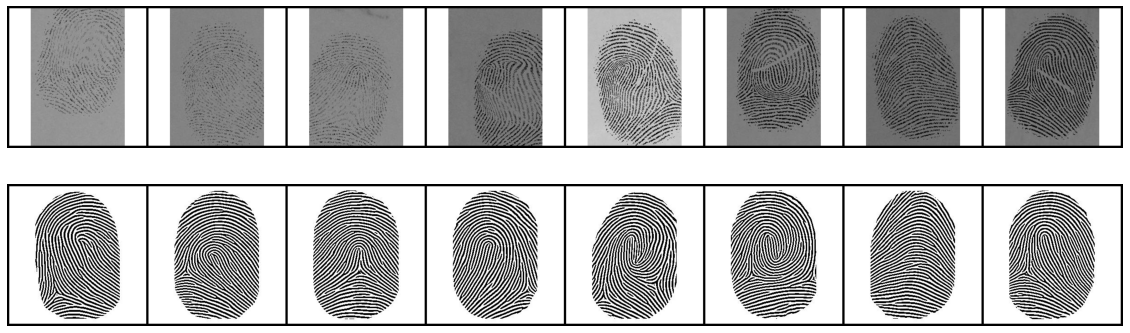

        same                same               same                same               diff                diff               same                same       

In [20]:
# Create the dataloader
#disp_dataset = dset.ImageFolder(root=data_dir)
disp_fingerprints = [str(finger) for finger in range(1,1000+1)]
disp_dataset = FingerprintLoader(target_dir, template_dir, num_train, disp_fingerprints)
disp_dataloader = torch.utils.data.DataLoader(disp_dataset, batch_size=8,
                                         shuffle=True, num_workers=1)

# Get a Batch of Sample Images
real_batch = next(iter(disp_dataloader))
batch = real_batch
labels = real_batch[3]

# Display the Sample Images
plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(2,1,2)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[2].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

c = 0
if labels is not None:
    for l in labels:
        if l == 1:
            print("        same       ", end="")
        else:
            print("        diff       ", end="")
        if c % 2 == 0:
            print(" ", end="")
        c += 1

## Generator

In [21]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(ResNetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        out = torch.relu(self.bn(self.conv(x)))
        out = self.bn(self.conv(out))
        out += x
        out = F.relu(out)
        return out
    

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1   = nn.Conv2d(nc, ngf, 7, 1, 3, bias=False)
        self.conv2   = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)
        self.conv3   = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.conv4   = nn.Conv2d(ngf, nc, 7, 1, 3, bias=False)
        # Transpose Convolutional Layers
        self.deconv1 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        # ResNet Layer
        self.resNet = ResNetBlock(ngf * 4, ngf * 4)
        # Batch Normalization Layers
        self.bn0 = nn.BatchNorm2d(ngf)
        self.bn1 = nn.BatchNorm2d(ngf * 2)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.bn3 = nn.BatchNorm2d(ngf * 8)


    def forward(self, x):
        out = F.relu(self.bn0(self.conv1(x)), True)
        out = F.relu(self.bn1(self.conv2(out)), True)
        out = F.relu(self.bn2(self.conv3(out)), True)
        out = F.relu(self.bn1(self.deconv1(out)), True)
        out = F.relu(self.bn0(self.deconv2(out)), True)
        out = torch.tanh(self.conv4(out))
        return out

In [22]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv1): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (deconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (resNet): ResNetBlock(
    (conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bn0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(1024, e

## Discriminator

In [23]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(3844, 1024)
        self.fc2 = nn.Linear(1225, 1)


    def forward(self, x):
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        #print(out.shape)
        #out = F.relu(self.fc1(out), 0.2)
        #print(out.shape)
        out = self.fc2(out)
        return torch.sigmoid(out)

In [24]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3844, out_features=1024, bias=True)
  (fc2): Linear(in_features=1225, out_features=1, bias=True)
)


## Set Training Params

In [28]:
num_train = 500000
batch_size = 32

# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)


# create data loaders
torch.manual_seed(1)

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}

# Create the dataloader
data_loader = get_train_loader(target_dir, template_dir, batch_size,num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader

# Create batch of latent vectors that we will use to visualize the progression of the generator
test_loader = get_train_loader(target_dir, template_dir, 8, num_train, num_valid, shuffle, **kwargs)
test_batch = []
test = next(iter(test_loader))
test_batch.append(test[0].to(device))     
test_batch.append(test[1].to(device))

criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

sim_label = 1.0
diff_label = 0.0

# Setup Adam optimizers for both G, D, and S
optimizerD = optim.Adam(netD.parameters(), lr=dlr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=glr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

## GAN Training


[*] Train on 500000 sample pairs

Epoch: 1/50


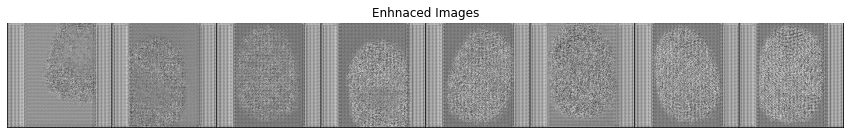

loss_D: 75.072959899902  loss_G: 73.417397   loss_S: 0.804852: 100%|██████████| 500000/500000 [3:18:49<00:00, 41.91it/s]   



Epoch: 2/50


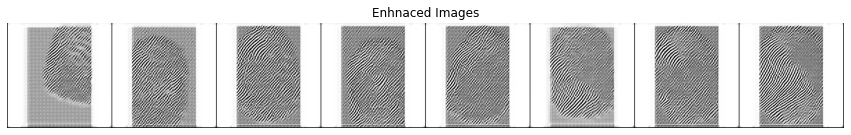

loss_D: 74.690711975098  loss_G: 72.518784   loss_S: 0.720551: 100%|██████████| 500000/500000 [3:16:55<00:00, 42.32it/s]  



Epoch: 3/50


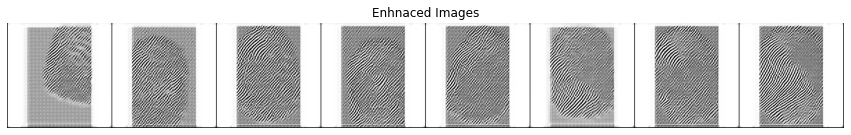

loss_D: 75.038490295410  loss_G: 73.093010   loss_S: 0.012511: 100%|██████████| 500000/500000 [4:57:48<00:00, 27.98it/s]   



Epoch: 4/50


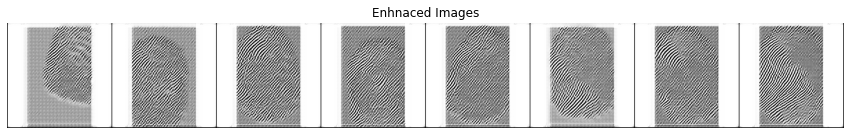

loss_D: 74.742767333984  loss_G: 73.589127   loss_S: 0.001589: 100%|██████████| 500000/500000 [4:57:36<00:00, 28.00it/s]  



Epoch: 5/50


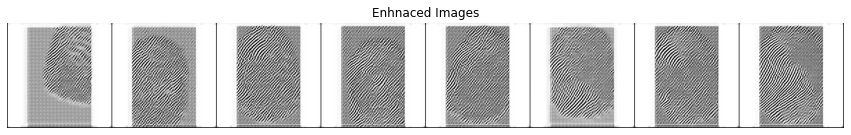

loss_D: 74.883987426758  loss_G: 73.463600   loss_S: 0.058092:  64%|██████▍   | 321728/500000 [3:11:19<1:45:51, 28.07it/s]

In [ ]:
# Train
num_epochs = 50

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
S_losses = []

errS = 0
iters = 0
# switch to train mode
netG.train()
netD.train()
# Load checkpoint
if os.path.isfile(model_ckpt_file):
    checkpoint = torch.load(model_ckpt_file)
    netG.load_state_dict(checkpoint['netG_state_dict'])
    netD.load_state_dict(checkpoint['netD_state_dict'])
    netS.load_state_dict(checkpoint['netS_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    optimizerS.load_state_dict(checkpoint['optimizerS_state_dict'])
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    S_losses = checkpoint['S_losses']
    img_list = checkpoint['img_list']
    test_batch = checkpoint['test_batch']
    iters = checkpoint['iters']
    start_epoch = checkpoint['epoch']

print("\n[*] Train on {} sample pairs".format(
    num_train, num_valid)
)

gLossMvAvg = MovingAvg()

for epoch in range(start_epoch, num_epochs+1):
    print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
    train_batch_time = AverageMeter()
    train_losses = AverageMeter()
    matching_correct = 0
    total_matched = 0
    # Plot the fake images from the last epoch
    with torch.no_grad():
        fake_disp = netG(test_batch[0]).detach().cpu()
        img_list.append(vutils.make_grid(fake_disp, padding=2, normalize=True))
        saveCkpt(model_ckpt_file, epoch, netG, netD, netS, optimizerG, optimizerD, optimizerS, G_losses, D_losses, S_losses, img_list, test_batch, iters)
    plt.figure(figsize=(15,15))
    plt.subplot(1,1,1)
    plt.axis("off")
    plt.title("Enhnaced Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    tic = time.time()
    with tqdm(total=num_train) as pbar:
        for i, (x1, enhanced_x1, x2, y) in enumerate(train_loader): 
            targ, enhanced_x1, temp, y = x1.to(device), enhanced_x1.to(device), x2.to(device), y.to(device)
            
            # Apply noise to images
            targ, temp, y = targ.to(device), temp.to(device), y.to(device)

            ############################
            # Update D network
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            b_size = temp.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(temp)
            output = output.view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward(retain_graph=True)
            D_x = output.mean().item()
            
            ## Train with all-GAN_Enhanced batch
            # Generate GAN_Enhanced image batch with G
            GAN_Enhanced = netG(targ)
            label.fill_(fake_label)
            # Classify all GAN_Enhanced batch with D
            output = netD(GAN_Enhanced.detach()).view(-1)
            # Calculate D's loss on the all-GAN_Enhanced batch
            errD_GAN_Enhanced = criterion(output, label)
            # Calculate the gradients for this batch
            errD_GAN_Enhanced.backward(retain_graph=True)
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-GAN_Enhanced batches
            errD = errD_real + errD_GAN_Enhanced
            # Update D
            optimizerD.step()
            
            ############################
            # Update S network
            ############################
            
            netS.zero_grad()
            train_match_output = netS(GAN_Enhanced, temp).view(-1)
            y = y.view(-1)
            errS = criterion(train_match_output, y)
            if epoch > 2:
                # Calculate the gradients for this batch
                errS.backward(retain_graph=True)
                # Update S
                optimizerS.step()
            
            
            ############################
            # Update G network
            ############################
            netG.zero_grad()
            label.fill_(real_label)  # GAN_Enhanced labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-GAN_Enhanced batch through D
            output = netD(GAN_Enhanced).view(-1)
            # Calculate G's loss based on this output
            errG_quality = criterion(output, label)
            # Calculate gradients for G
            errG_quality.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
                        
            # Use S update G based on Similarity of GAN_Enhanced Image to the Real Image
            y = y.view(-1)
            output = netS(GAN_Enhanced.detach(), temp).view(-1)
            # Calculate G's loss based on this output
            errG_sim = criterion(output, y)
            # Calculate gradients for G
            errG_sim.backward()
            # Add the gradients
            if epoch > 2:
                errG = errG_quality + errG_sim
            else:
                errG = errG_quality 

            # Update G
            optimizerG.step()
            
            # store batch statistics
            toc = time.time()
            train_batch_time.update(toc-tic)
            tic = time.time()
            pbar.set_description(
                (
                    "loss_D: {:.12f}  loss_G: {:.6f}   loss_S: {:.6f}".format(
                        errD.item(), errG.item(), errS.item()
                    )
                )
            )
            pbar.update(batch_size)
            
            gLossMvAvg.push(errG.item())
            
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            S_losses.append(errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 5000 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = netG(test_batch[0]).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                saveCkpt(model_ckpt_file, epoch, netG, netD, netS, optimizerG, optimizerD, optimizerS, G_losses, D_losses, S_losses, img_list, test_batch, iters)

            iters += 1                  

# Save results
saveCkpt(model_ckpt_file, epoch, netG, netD, netS, optimizerG, optimizerD, optimizerS, G_losses, D_losses, S_losses, img_list, test_batch, iters)

## Results

### Training Loss

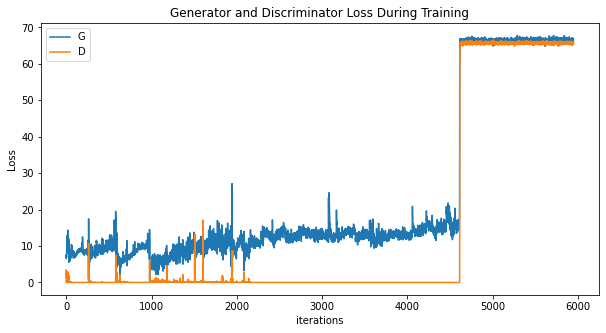

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Animation of Generator Progression.

Below is an animation of the generator's progression throughout training. Note, for each frame, the generator was fed the same batch of sample images as input.

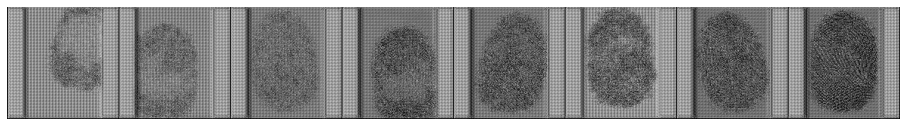

In [55]:
#%%capture
fig = plt.figure(figsize=(16,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Side by Side Comparison of Real and Fake Images
* Left: Real Images
* Middle: Generated Images
* Right: Real Images

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(test_loader))

# Plot the noisy images
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(3,1,2)
plt.axis("off")
plt.title("Enhnaced Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

# Plot the real images
plt.subplot(3,1,3)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[1].to(device)[:], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()